# Mixture Density Network

This notebook trains a simple gaussian mixture density network from basic statistics of the predictive distributions coming from the component models.

In [92]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../src")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import data
import utils
import losses

from functools import partial

from keras.layers import (Activation, Dense, Dropout, Embedding, Flatten, Merge, Reshape)
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import keras.backend as K
from sklearn.model_selection import train_test_split
from scipy.stats import norm

## Load data

In [94]:
kcde_dl = data.ComponentDataLoader("../data", "kcde")
kde_dl = data.ComponentDataLoader("../data", "kde")
sarima_dl = data.ComponentDataLoader("../data", "sarima")

actual_dl = data.ActualDataLoader("../data")

### Working on week ahead predictions

We need to take the common row entries (common "epiweek", "region") for each data item, i.e. actual data and component data.

In [95]:
REGION = "nat" # Specify None for using all the data
WEEK_TARGETS = ["one_wk", "two_wk", "three_wk", "four_wk"]
WEEK_NUMBER = 1

actual_idx, actual_data = actual_dl.get(week_shift=WEEK_NUMBER, region_identifier=REGION)
kde_idx, kde_data = kde_dl.get(WEEK_TARGETS[WEEK_NUMBER - 1], region_identifier=REGION)
kcde_idx, kcde_data = kcde_dl.get(WEEK_TARGETS[WEEK_NUMBER - 1], region_identifier=REGION)
sarima_idx, sarima_data = sarima_dl.get(WEEK_TARGETS[WEEK_NUMBER - 1], region_identifier=REGION)

In [96]:
actual_filter, kde_filter, kcde_filter, sarima_filter= data.filter_common_indices(actual_idx, kde_idx, kcde_idx, sarima_idx)

Creating well formed tensors for input

In [97]:
y = actual_data[actual_filter]

# Skipping the last bin in distributions
X_kde = np.exp(kde_data[kde_filter][:, :-1])
X_kcde = np.exp(kcde_data[kcde_filter][:, :-1])
X_sarima = np.exp(sarima_data[sarima_filter][:, :-1])

### Extracting statistical features from the distributions

We are just using the mean and std of distributions and concatenating to a single vector as input to the model

In [98]:
X_mean = np.array([
    [utils.dist_mean(dist) for dist in comp_dist]
    for comp_dist in [X_kde, X_kcde, X_sarima]
]).T
X_std = np.array([
    [utils.dist_std(dist) for dist in comp_dist]
    for comp_dist in [X_kde, X_kcde, X_sarima]
]).T

In [99]:
X = np.concatenate([X_mean, X_std], axis=1)

In [100]:
X_train, X_test, X_kde_train, X_kde_test, X_kcde_train, X_kcde_test, X_sarima_train, X_sarima_test, y_train, y_test = train_test_split(X, X_kde, X_kcde, X_sarima, y, test_size=0.2, random_state=1234)

## Model

The model is a simple mixture density network which returns a set of parameters which are then used in the loss function to get the negative log score for optimization

In [145]:
def mdn(n_input, n_mix):
    """
    Return a mixture density model with given number of mixtures (gaussians)
    """
    
    model = Sequential()
    model.add(Dense(20, input_shape=(n_input,)))
    model.add(Activation("relu"))
    model.add(Dense(20))
    model.add(Activation("relu"))
    model.add(Dense(10))
    model.add(Activation("relu"))
    
    # Return 3 parameters, mu, sigma and mixture weight
    model.add(Dense(n_mix * 3))
    
    return model

In [223]:
N_MIX = 2
model = mdn(6, N_MIX)
loss_fn = partial(losses.mdn_loss, n_mix=N_MIX)
loss_fn.__name__ = "mdn_loss" # Keras needs a name for function

In [224]:
model.compile(optimizer="rmsprop", loss=loss_fn)

early_stop = EarlyStopping(monitor="val_loss", patience=4, mode="auto")

history = model.fit(X_train,
                    y_train,
                    batch_size=64, epochs=100,
                    verbose=0,
                    callbacks=[early_stop],
                    validation_split=0.2)

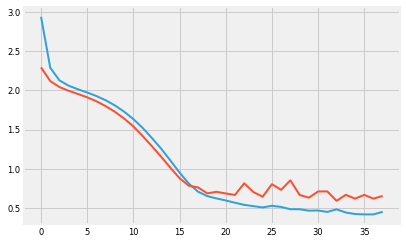

In [225]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

### Evaluation

In [226]:
y_one_hot = utils.wili_to_dists(y_test)
ensemble_dists = utils.mdn_params_to_dists(model.predict(X_test))

for name, output in zip(
    ["kde", "kcde", "sarima", "ensemble"],
    [X_kde_test, X_kcde_test, X_sarima_test, ensemble_dists]
):
    print(f"{name}: {K.categorical_crossentropy(output, y_one_hot).mean().eval()}")

kde: 3.4951295478817626
kcde: 3.031170673911367
sarima: 3.0396202942149895
ensemble: 2.74724302588436


## Plot random predictions

In [228]:
# n_plots = 10
# idx = np.random.randint(0, y_test.shape[0], size=n_plots)

# kde_out = X_kde_test[idx]
# kcde_out = X_kcde_test[idx]
# sarima_out = X_sarima_test[idx]
# y_out = y[idx]

# dist_mean = np.array([
#     [utils.dist_mean(dist) for dist in comp_dist]
#     for comp_dist in [kde_out, kcde_out, sarima_out]
# ]).T
# dist_std = np.array([
#     [utils.dist_std(dist) for dist in comp_dist]
#     for comp_dist in [kde_out, kcde_out, sarima_out]
# ]).T

# # Prediction from model
# model_out = model.predict(np.concatenate([dist_mean, dist_std], axis=1))
# ensemble_out = utils.mdn_params_to_dists(model_out)

# bins = np.linspace(0, 12.9, 130)

# for i in range(n_plots):
#     plt.figure(figsize=(14, 6))
#     plt.plot(bins, kde_out[i], label="kde")
#     plt.plot(bins, kcde_out[i], label="kcde")
#     plt.plot(bins, sarima_out[i], label="sarima")
#     plt.plot(bins, ensemble_out[i], label="ensemble")
    
#     # Plot actual line
#     plt.axvline(x=y_out[i])
    
#     plt.legend()